# Курсовой проект

#### Подключение необходимых библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

%matplotlib inline

#### Используемые функции

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
def home_ownership2freq(df):
    freq_encode_ownership = df.groupby('Home Ownership').size()/len(df)
    res = df['Home Ownership'].map(freq_encode_ownership)
    return res

In [5]:
def home_ownership2bins(df):
    hown_bins = []
    for hown in np.unique(df['Home Ownership']):
        hown_bins.append([hown])
    
    for count, pbin in enumerate(hown_bins):
        df[f'is_hown_bin_{count}'] = np.where(df['Home Ownership'].isin(pbin), 1, 0).astype('float64')

In [6]:
def term2freq(df):
    freq_encode_term = df.groupby('Term').size()/len(df)
    res = df['Term'].map(freq_encode_term)
    return res

In [7]:
def term2bins(df):
    term_bins = []
    for term in np.unique(df['Term']):
        term_bins.append([term])
    
    for count, pbin in enumerate(term_bins):
        df[f'is_term_bin_{count}'] = np.where(df['Term'].isin(pbin), 1, 0).astype('float64')

In [8]:
def get_mse(check_test):
    check_test["error"] = check_test["y_pred"] - check_test["y_test"]
    mse1 = (check_test["error"] ** 2).mean()
    return mse1

In [9]:
def get_f1(check_test):
    f1 = f1_score(check_test['y_test'], check_test['y_pred'], average="micro")
    return f1

In [10]:
def classify_by_threshold(y_in, threshold):
    y_out = np.where(y_in > threshold, 1, 0)
    return y_out

#### Загрузка наборов данных

In [11]:
DATA_TRAIN_PATH = "./course_project_train.csv"
DATA_TEST_PATH = "./course_project_test.csv"

In [12]:
train_ds = pd.read_csv(DATA_TRAIN_PATH)
test_ds = pd.read_csv(DATA_TEST_PATH)


In [13]:
data = pd.concat([train_ds, test_ds], axis=0)
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

#### Первоначальные замечания по данным

1. В данных есть пропуски. В столбцах: 
    - Annual Income, 
    - Years in current job, 
    - Months since last delinquent, 
    - Bankruptcies, 
    - Credit Score
2. 4 столбца типа object:
    - Home Ownership,
    - Years in current job,
    - Purpose,
    - Term

#### Получение списка столбцов и деление на основные свойства и целевую переменную

In [15]:
list(data.columns)

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [16]:
BASE_FEATURE_NAMES  = ['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']
TARGET_NAME = ['Credit Default']

# Анализ

### Преобразования столбцов типа object

#### Преобразование столбца "Years in current job"

In [17]:
curr_job_years = data['Years in current job']
curr_job_years.value_counts()

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

In [18]:
curr_job_years.describe()

count          9543
unique           11
top       10+ years
freq           3142
Name: Years in current job, dtype: object

In [19]:
cj_years_substitution = {'10+ years':21, '9 years':18, '8 years':16, '7 years':14, '6 years':12, '5 years':10, 
                        '4 years':8, '3 years':6, '2 years':4, '1 year':2, '< 1 year':1, '0':20}
cj_years_substitution['0']

20

In [20]:
int_years = map(lambda x: cj_years_substitution[x], curr_job_years.fillna('0').astype(str))


In [21]:
data['Years in current job'] = pd.DataFrame(list(int_years))
data['Years in current job']

0       20
1       21
2       16
3       12
4       16
        ..
2495     4
2496    12
2497    21
2498    20
2499    21
Name: Years in current job, Length: 10000, dtype: int64

<AxesSubplot:>

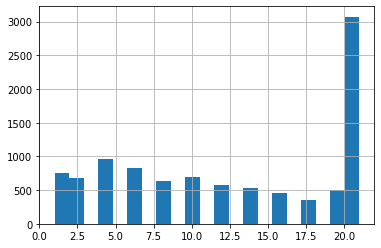

In [22]:
data['Years in current job'].hist(bins=21)

In [23]:
data['Years in current job'].describe()

count    10000.000000
mean        12.506800
std          7.498865
min          1.000000
25%          6.000000
50%         12.000000
75%         21.000000
max         21.000000
Name: Years in current job, dtype: float64

In [24]:
data['Years in current job'] = data['Years in current job'].astype(float)

#### Преобразование столбца "Home Ownership"

In [25]:
home_ownership = data['Home Ownership']
home_ownership.value_counts()

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64

In [26]:
#freq_encode_ownership = data.groupby('Home Ownership').size()/len(data)
#data.loc[:, 'freq_encode_ownership'] = data['Home Ownership'].map(freq_encode_ownership)
#data

In [27]:
data.loc[:, 'freq_encode_ownership'] = home_ownership2freq(data)


In [28]:
home_ownership2bins(data)


#### Преобразование столбца "Purpose"


In [29]:
purpose = data['Purpose']
purpose.value_counts()

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64

In [30]:
purpose_bins = []
purpose_bins.append(['business loan'])
purpose_bins.append(['debt consolidation'])
purpose_bins.append(list(set(purpose.values) - set(purpose_bins[0]) -set(purpose_bins[1])))

In [31]:
purpose_bins

[['business loan'],
 ['debt consolidation'],
 ['educational expenses',
  'major purchase',
  'renewable energy',
  'take a trip',
  'vacation',
  'buy house',
  'home improvements',
  'medical bills',
  'wedding',
  'small business',
  'moving',
  'buy a car',
  'other']]

In [32]:
for purpose in np.unique(data['Purpose']):
    for count, pbin in enumerate(purpose_bins):
        data[f'is_purpose_bin_{count}'] = np.where(data['Purpose'].isin(pbin), 1, 0).astype('float64')

In [33]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,freq_encode_ownership,is_hown_bin_0,is_hown_bin_1,is_hown_bin_2,is_hown_bin_3,is_purpose_bin_0,is_purpose_bin_1,is_purpose_bin_2
0,Own Home,482087.0,20.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,749.0,0.0,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Own Home,1025487.0,21.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,737.0,1.0,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Home Mortgage,751412.0,16.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,742.0,0.0,0.4862,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,Own Home,805068.0,12.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,694.0,0.0,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,Rent,776264.0,16.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,719.0,0.0,0.4224,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [34]:
IS_DATA_COLUMNS = ['is_purpose_bin_0', 'is_purpose_bin_1', 'is_purpose_bin_2']

Определяем влияние разбитых данных для цели кредита на итоговый результат. По сути is_purpose_bin_2 могла бы и не учитываться.

<AxesSubplot:>

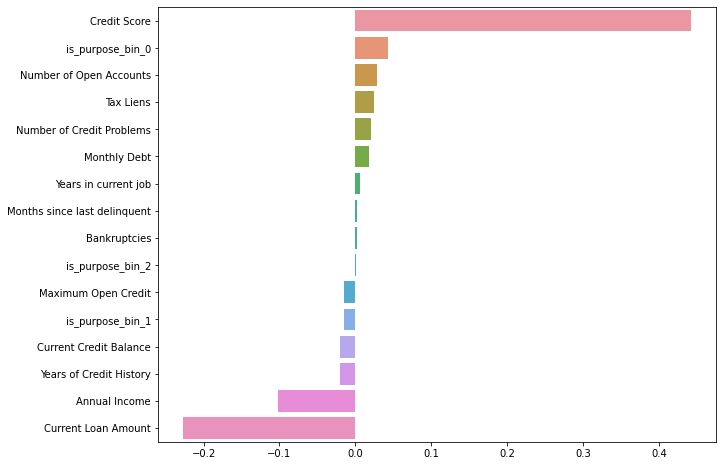

In [35]:
corr_with_target = data[BASE_FEATURE_NAMES+IS_DATA_COLUMNS+TARGET_NAME].corr().iloc[:-1,-1].sort_values(ascending = False)
plt.figure(figsize=(10,8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

In [36]:
train_data = data[(data['Credit Default'].notnull())]

In [37]:
scores = {}
for feature in IS_DATA_COLUMNS:
    scores[feature] = 2*roc_auc_score(y_true=train_data[TARGET_NAME], y_score=train_data[feature].fillna(-9999)) - 1
    
scores = pd.Series(scores)    


Еще один график влияния цели кредита на результат

<AxesSubplot:>

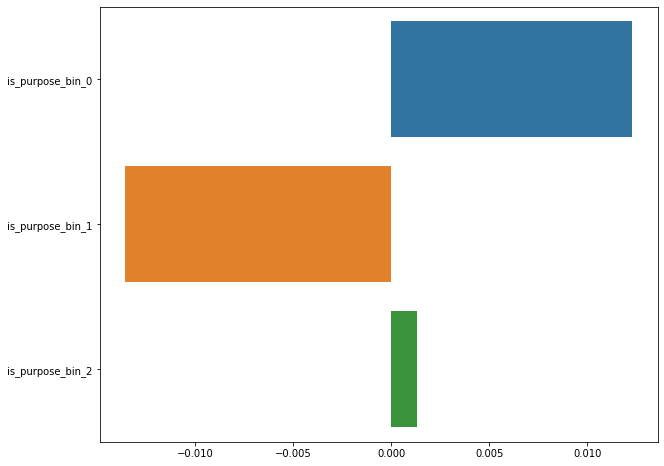

In [38]:
plt.figure(figsize=(10,8))
sns.barplot(x=scores.values, y=scores.index)

#### Преобразование столбца "Terms"

In [39]:
data['Term'].value_counts()

Short Term    7417
Long Term     2583
Name: Term, dtype: int64

Разбиваем по классам

In [40]:
term2bins(data)
data[['is_term_bin_0', 'is_term_bin_1']].head()

,is_term_bin_0,is_term_bin_1
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


### Обработка пропусков в данных

Поле 'Annual Income' и поле 'Credit Score' имеют одно и то же количество незаполненных записей. Нет одни ли и те же это записи?

In [41]:
income_score = train_ds.loc[(train_ds['Annual Income'].isnull()) & (train_ds['Credit Score'].isnull()), ['Annual Income', 'Credit Score']]
income_score

,Annual Income,Credit Score
5,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN
16,NaN,NaN
...,...,...
7482,NaN,NaN
7492,NaN,NaN
7494,NaN,NaN
7498,NaN,NaN


Количество записей, для которых оба столбца незаполнены составляет 1557. Так как 1557+5943 = 7500 можно сделать вывод, что записи, в которых не заполнены оба столбца - одни и те же.


In [42]:
income_score = data.loc[(data['Annual Income'].isnull()) & (data['Credit Score'].isnull()), ['Annual Income', 'Credit Score']]
income_score

,Annual Income,Credit Score
5,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN
16,NaN,NaN
...,...,...
2469,NaN,NaN
2475,NaN,NaN
2479,NaN,NaN
2487,NaN,NaN


Количество записей, для которых оба столбца незаполнены составляет 2070. Так как 2070+7930 = 10000 можно сделать вывод, что записи, в которых не заполнены оба столбца для одновременно тестовой и обучающей выборки - одни и те же.

In [43]:
train_ds['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [44]:
train_ds['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

#### Преобразование столбца "Months since last delinquent"

<AxesSubplot:>

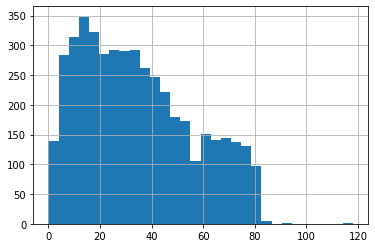

In [45]:
data['Months since last delinquent'].hist(bins=30)

In [46]:
data['Number of Credit Problems'].value_counts()

0.0     8646
1.0     1162
2.0      122
3.0       42
5.0       11
4.0       10
6.0        4
7.0        2
15.0       1
Name: Number of Credit Problems, dtype: int64

<AxesSubplot:>

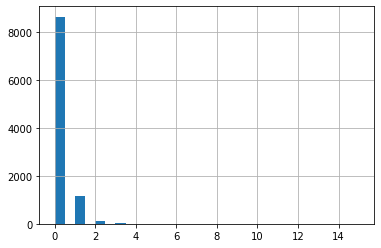

In [47]:
data['Number of Credit Problems'].hist(bins=30)

In [48]:
nndata = data[data['Months since last delinquent'].notnull()]
nndata['Months since last delinquent'].describe()

count    4561.000000
mean       34.564569
std        21.771990
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [49]:
data['Months since last delinquent'].fillna(32, inplace=True)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          10000 non-null  float64
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  10000 non-null  float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

In [51]:
data[data['Bankruptcies'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,freq_encode_ownership,is_hown_bin_0,is_hown_bin_1,is_hown_bin_2,is_hown_bin_3,is_purpose_bin_0,is_purpose_bin_1,is_purpose_bin_2,is_term_bin_0,is_term_bin_1
100,Own Home,337079.0,2.0,0.0,9.0,39.6,644204.0,0.0,0.0,NaN,...,0.0895,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
256,Rent,857660.0,2.0,0.0,6.0,19.7,291082.0,0.0,0.0,NaN,...,0.4224,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
257,Home Mortgage,NaN,4.0,0.0,15.0,13.6,1556390.0,0.0,0.0,NaN,...,0.4862,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
898,Rent,739005.0,4.0,0.0,20.0,18.3,2177758.0,0.0,0.0,NaN,...,0.4224,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1404,Rent,349391.0,1.0,0.0,4.0,12.7,0.0,0.0,0.0,NaN,...,0.4224,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [52]:
data['Bankruptcies'].value_counts()

0.0    8912
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64

In [53]:
data['Bankruptcies'].describe()

count    9983.000000
mean        0.114595
std         0.349729
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: Bankruptcies, dtype: float64

Заполняем пропуски по медиане

In [54]:
data['Bankruptcies'] = data['Bankruptcies'].fillna(0)

#### Выбросы для данных Credit Score

<AxesSubplot:>

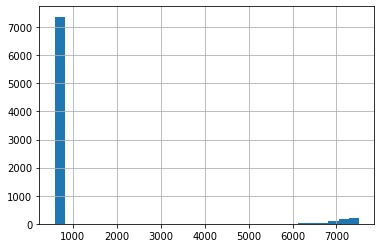

In [55]:
data['Credit Score'].hist(bins=30)

In [56]:
data.loc[data['Credit Score']>5000, 'Credit Score'].describe()

count     560.000000
mean     7112.482143
std       304.097391
min      6060.000000
25%      6960.000000
50%      7190.000000
75%      7340.000000
max      7510.000000
Name: Credit Score, dtype: float64

Некоторое количество данных Credit Score в десять раз отличается от основного объема. Предположим, что это ошибка в данных и их нужно исправить.

In [57]:
data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if x>5000 else x)

#### Annual Income and Credit Score

Для этих параметров применим линейную регрессию для заполнения пропущенных данных

In [58]:
income_data = data[(data['Annual Income'].notnull()) & (data['Credit Score'].notnull())]
income_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,freq_encode_ownership,is_hown_bin_0,is_hown_bin_1,is_hown_bin_2,is_hown_bin_3,is_purpose_bin_0,is_purpose_bin_1,is_purpose_bin_2,is_term_bin_0,is_term_bin_1
0,Own Home,482087.0,20.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Own Home,1025487.0,21.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Home Mortgage,751412.0,16.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,0.4862,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Own Home,805068.0,12.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Rent,776264.0,16.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0.4224,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [59]:
income_data_num = income_data.select_dtypes(include='float64')

In [60]:
income_data_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7930 entries, 0 to 2499
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7930 non-null   float64
 1   Years in current job          7930 non-null   float64
 2   Tax Liens                     7930 non-null   float64
 3   Number of Open Accounts       7930 non-null   float64
 4   Years of Credit History       7930 non-null   float64
 5   Maximum Open Credit           7930 non-null   float64
 6   Number of Credit Problems     7930 non-null   float64
 7   Months since last delinquent  7930 non-null   float64
 8   Bankruptcies                  7930 non-null   float64
 9   Current Loan Amount           7930 non-null   float64
 10  Current Credit Balance        7930 non-null   float64
 11  Monthly Debt                  7930 non-null   float64
 12  Credit Score                  7930 non-null   float64
 13  Cre

INCOME_FEATURE_NAMES - столбцы, которые будут масштабироваться

BIN_FEATURE_NAMES - столбцы классификации one-hot

In [61]:
INCOME_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                      'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Years in current job',
                       'freq_encode_ownership'
                         ]

BIN_FEATURE_NAMES = ['is_hown_bin_0',
 'is_hown_bin_1',
 'is_hown_bin_2',
 'is_hown_bin_3',
 'is_purpose_bin_0',
 'is_purpose_bin_1',
 'is_purpose_bin_2',
 'is_term_bin_0',
 'is_term_bin_1']



In [62]:
def lin_regression_annual_income(df, features, bin_features, target):
    scaler = StandardScaler()
    
    df_norm = df.copy()
    df_norm[features[1:]] = scaler.fit_transform(df_norm[features].drop(columns=target))
    df = df_norm.copy()
    
    
    X_train, X_test, y_train, y_test = \
        train_test_split(df[features+bin_features].drop(columns=target), df[target], test_size=0.3)
        #train_test_split(df.drop(columns=target), df[target], test_size=0.3)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)    
    y_pred = lr.predict(X_test)
    
    check_test = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred.flatten(),
    })
    check_test["error"] = check_test["y_pred"] - check_test["y_test"]
    mean_squared_error(check_test["y_pred"], check_test["y_test"])
    lr.coef_

    
    plt.rcParams['figure.figsize'] = 6, 4


    plt.barh(sorted(df[features+bin_features].drop(columns=target)), lr.coef_.flatten())

    plt.xlabel("Вес признака")
    plt.ylabel("Признак")

    plt.show()
    
    return (scaler, lr)

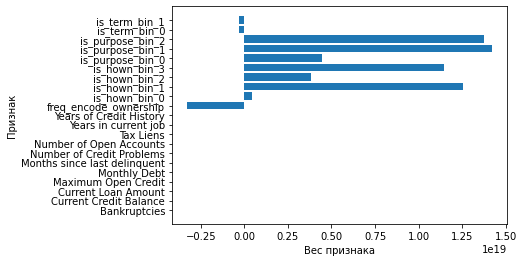

In [63]:
lin_scaler, lr = lin_regression_annual_income(income_data_num[income_data_num['Annual Income'].notnull()], 
                                                              INCOME_FEATURE_NAMES+BIN_FEATURE_NAMES, [],
                                                              'Annual Income')

Формируем отмасштабированные данные для ответов линейной регрессии

In [64]:
df_norm = data[data['Annual Income'].isnull()].copy()
df_norm[INCOME_FEATURE_NAMES[1:]+BIN_FEATURE_NAMES] = \
                lin_scaler.transform(df_norm[INCOME_FEATURE_NAMES[1:]+BIN_FEATURE_NAMES])
data_ai = df_norm.copy()


In [65]:
data_ai.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,freq_encode_ownership,is_hown_bin_0,is_hown_bin_1,is_hown_bin_2,is_hown_bin_3,is_purpose_bin_0,is_purpose_bin_1,is_purpose_bin_2,is_term_bin_0,is_term_bin_1
5,Rent,NaN,0.199606,-0.099409,0.178534,-0.525605,-0.077097,-0.320239,-0.080994,-0.323543,...,-0.002937,-0.042054,-0.977307,-0.315284,1.176844,-0.128594,-1.964451,2.067877,1.658669,-1.658669
8,Home Mortgage,NaN,-0.333348,-0.099409,1.202233,-0.370273,-0.145152,1.599258,-0.080994,2.495905,...,0.571845,-0.042054,1.023220,-0.315284,-0.849730,-0.128594,-1.964451,2.067877,-0.602893,0.602893
9,Home Mortgage,NaN,-1.399255,-0.099409,-0.230945,0.886502,-0.050282,-0.320239,-1.836782,-0.323543,...,0.571845,-0.042054,1.023220,-0.315284,-0.849730,-0.128594,0.509048,-0.483588,1.658669,-1.658669
10,Home Mortgage,NaN,-1.532493,-0.099409,-0.845165,-0.963358,-0.097592,-0.320239,-0.080994,-0.323543,...,0.571845,-0.042054,1.023220,-0.315284,-0.849730,-0.128594,0.509048,-0.483588,-0.602893,0.602893
16,Rent,NaN,0.199606,-0.099409,-1.049905,-0.073730,0.021745,-0.320239,-0.080994,-0.323543,...,-0.002937,-0.042054,-0.977307,-0.315284,1.176844,-0.128594,0.509048,-0.483588,1.658669,-1.658669


Предсказание данных в столбце Annual Income

In [66]:
data.loc[data['Annual Income'].isnull(), ['Annual Income']] = \
    lr.predict(data_ai.loc[data_ai['Annual Income'].isnull(), \
                        INCOME_FEATURE_NAMES+BIN_FEATURE_NAMES].drop(columns='Annual Income')) 

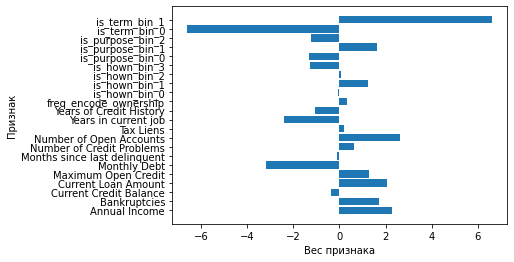

In [67]:
lin_scaler, lr_cscore = \
    lin_regression_annual_income(income_data_num, ['Credit Score']+INCOME_FEATURE_NAMES+BIN_FEATURE_NAMES, [], 
                                 'Credit Score')

Формируем отмасштабированные данные для ответов линейной регрессии

In [68]:
df_norm = data[data['Credit Score'].isnull()].copy()
df_norm[INCOME_FEATURE_NAMES+BIN_FEATURE_NAMES] = \
        lin_scaler.transform(df_norm[INCOME_FEATURE_NAMES+BIN_FEATURE_NAMES])
data_cs = df_norm.copy()

In [69]:
data_cs.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,freq_encode_ownership,is_hown_bin_0,is_hown_bin_1,is_hown_bin_2,is_hown_bin_3,is_purpose_bin_0,is_purpose_bin_1,is_purpose_bin_2,is_term_bin_0,is_term_bin_1
5,Rent,0.008815,0.199606,-0.099409,0.178534,-0.525605,-0.077097,-0.320239,-0.080994,-0.323543,...,-0.002937,-0.042054,-0.977307,-0.315284,1.176844,-0.128594,-1.964451,2.067877,1.658669,-1.658669
8,Home Mortgage,-0.760979,-0.333348,-0.099409,1.202233,-0.370273,-0.145152,1.599258,-0.080994,2.495905,...,0.571845,-0.042054,1.023220,-0.315284,-0.849730,-0.128594,-1.964451,2.067877,-0.602893,0.602893
9,Home Mortgage,0.183528,-1.399255,-0.099409,-0.230945,0.886502,-0.050282,-0.320239,-1.836782,-0.323543,...,0.571845,-0.042054,1.023220,-0.315284,-0.849730,-0.128594,0.509048,-0.483588,1.658669,-1.658669
10,Home Mortgage,-0.138297,-1.532493,-0.099409,-0.845165,-0.963358,-0.097592,-0.320239,-0.080994,-0.323543,...,0.571845,-0.042054,1.023220,-0.315284,-0.849730,-0.128594,0.509048,-0.483588,-0.602893,0.602893
16,Rent,0.059495,0.199606,-0.099409,-1.049905,-0.073730,0.021745,-0.320239,-0.080994,-0.323543,...,-0.002937,-0.042054,-0.977307,-0.315284,1.176844,-0.128594,0.509048,-0.483588,1.658669,-1.658669


Предсказание данных в столбце Credit Score

In [70]:
data.loc[data['Credit Score'].isnull(), ['Credit Score']] = \
    lr_cscore.predict(data_cs.loc[data_cs['Credit Score'].isnull(), \
                        ['Credit Score']+INCOME_FEATURE_NAMES+BIN_FEATURE_NAMES].drop(columns='Credit Score'))

In [71]:
data['Annual Income'].describe()

count    1.000000e+04
mean     1.364858e+06
std      8.046757e+05
min      1.065330e+05
25%      8.754820e+05
50%      1.205142e+06
75%      1.629025e+06
max      1.497561e+07
Name: Annual Income, dtype: float64

In [72]:
data['Credit Score'].describe()


count    10000.000000
mean       719.985864
std         25.778176
min        585.000000
25%        708.000000
50%        726.463444
75%        738.000000
max       1055.888727
Name: Credit Score, dtype: float64

#### Проверка, что все данные подготовлены

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 10000 non-null  float64
 2   Years in current job          10000 non-null  float64
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  10000 non-null  float64
 9   Bankruptcies                  10000 non-null  float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

------------------------------------------------------------------

In [74]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                      'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Years in current job',
                       'Credit Score'
                         ]
                    

TARGET_NAME = 'Credit Default'

#### Разбиение на тестовую и тренировочную выборки

In [75]:
train_set = data[data['Credit Default'].notnull()]
test_set = data[data['Credit Default'].isnull()]

#### Балансировка

In [76]:

balanced_data = balance_df_by_target(train_set, TARGET_NAME)
balanced_data

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,freq_encode_ownership,is_hown_bin_0,is_hown_bin_1,is_hown_bin_2,is_hown_bin_3,is_purpose_bin_0,is_purpose_bin_1,is_purpose_bin_2,is_term_bin_0,is_term_bin_1
7741,Home Mortgage,1.812771e+06,21.0,0.0,10.0,19.6,620026.0,0.0,32.0,0.0,...,0.4862,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8337,Rent,1.428287e+06,4.0,0.0,19.0,15.3,522698.0,0.0,32.0,0.0,...,0.4224,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
7551,Own Home,7.238030e+05,1.0,0.0,9.0,15.2,554598.0,0.0,32.0,0.0,...,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6984,Rent,1.625564e+06,21.0,1.0,7.0,18.7,332992.0,2.0,1.0,1.0,...,0.4224,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9586,Home Mortgage,2.272571e+06,21.0,0.0,19.0,44.5,891990.0,0.0,32.0,0.0,...,0.4862,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3896,Own Home,2.329875e+06,14.0,0.0,4.0,16.2,107580.0,0.0,32.0,0.0,...,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1237,Own Home,1.215240e+06,21.0,0.0,11.0,18.7,1230548.0,0.0,7.0,0.0,...,0.0895,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3914,Rent,9.398350e+05,6.0,0.0,13.0,5.6,376002.0,0.0,32.0,0.0,...,0.4224,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4707,Rent,8.814670e+05,21.0,0.0,10.0,17.5,104016.0,0.0,32.0,0.0,...,0.4224,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [77]:
X = balanced_data.drop(columns='Credit Default').select_dtypes(include='float64')
y = balanced_data['Credit Default']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Проверка моделей

### Линейная регрессия

In [79]:
lr = LinearRegression()

In [80]:
lr.fit(X_train, y_train)

LinearRegression()

In [81]:
y_pred = lr.predict(X_test)
y_tr_pred = lr.predict(X_train)


#### Определение порога для значения классу  0 или 1

In [102]:
maxf1 = 0
maxth = -1 
for th in np.arange(-1,1, 0.01):
    y_out = classify_by_threshold(y_pred, th)
    check_test = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_out.flatten(),
    })
    f1 = get_f1(check_test)
    print(f"threshold {th}, mse {get_mse(check_test)}, f1 {f1}")
    if (f1>maxf1):
        maxf1 = f1
        maxth = th

threshold -1.0, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.99, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.98, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.97, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.96, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.95, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.94, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.9299999999999999, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.9199999999999999, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.9099999999999999, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.8999999999999999, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.8899999999999999, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.8799999999999999, mse 0.5655339805825242, f1 0.43446601941747565
threshold -0.8699999999999999, mse 0.5655339805825242, f1 0.43446601941747565
thresho

threshold 0.4600000000000013, mse 0.3658113730929265, f1 0.6341886269070736
threshold 0.4700000000000013, mse 0.35852981969486825, f1 0.6414701803051318
threshold 0.4800000000000013, mse 0.34812760055478503, f1 0.651872399445215
threshold 0.4900000000000013, mse 0.3418862690707351, f1 0.658113730929265
threshold 0.5000000000000013, mse 0.3422330097087379, f1 0.6577669902912622
threshold 0.5100000000000013, mse 0.34535367545076284, f1 0.6546463245492372
threshold 0.5200000000000014, mse 0.3509015256588072, f1 0.6490984743411928
threshold 0.5300000000000014, mse 0.3540221914008322, f1 0.6459778085991679
threshold 0.5400000000000014, mse 0.3522884882108183, f1 0.6477115117891817
threshold 0.5500000000000014, mse 0.3488210818307906, f1 0.6511789181692095
threshold 0.5600000000000014, mse 0.3592233009708738, f1 0.6407766990291263
threshold 0.5700000000000014, mse 0.36234396671289876, f1 0.6376560332871013
threshold 0.5800000000000014, mse 0.36789181692094314, f1 0.6321081830790569
threshold

Максимальное значение f-меры получается при пороге присвоения для классов


In [103]:
print(f"f1 = {maxf1}, threshold={maxth}")

f1 = 0.658113730929265, threshold=0.4900000000000013


### Логистическая регрессия

In [83]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)
print(f"LogRegression pred {y_test_pred}")

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

LogRegression pred [1. 1. 0. ... 0. 1. 0.]
TRAIN

              precision    recall  f1-score   support

         0.0       0.60      0.77      0.67      3756
         1.0       0.55      0.36      0.44      2973

    accuracy                           0.59      6729
   macro avg       0.58      0.56      0.56      6729
weighted avg       0.58      0.59      0.57      6729

TEST

              precision    recall  f1-score   support

         0.0       0.62      0.77      0.68      1631
         1.0       0.55      0.38      0.45      1253

    accuracy                           0.60      2884
   macro avg       0.58      0.57      0.57      2884
weighted avg       0.59      0.60      0.58      2884

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1251  380
1.0              781  472


### Knn

In [84]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      3756
         1.0       0.76      0.90      0.83      2973

    accuracy                           0.83      6729
   macro avg       0.83      0.84      0.83      6729
weighted avg       0.84      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65      1631
         1.0       0.55      0.62      0.58      1253

    accuracy                           0.62      2884
   macro avg       0.62      0.62      0.62      2884
weighted avg       0.62      0.62      0.62      2884

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1010  621
1.0              481  772


### XGB

In [85]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      3756
         1.0       0.96      0.97      0.96      2973

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.77      1631
         1.0       0.70      0.77      0.73      1253

    accuracy                           0.75      2884
   macro avg       0.75      0.76      0.75      2884
weighted avg       0.76      0.75      0.76      2884

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1216  415
1.0              293  960


### LGBM

In [86]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      3756
         1.0       0.89      0.88      0.89      2973

    accuracy                           0.90      6729
   macro avg       0.90      0.90      0.90      6729
weighted avg       0.90      0.90      0.90      6729

TEST

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      1631
         1.0       0.68      0.71      0.69      1253

    accuracy                           0.73      2884
   macro avg       0.72      0.73      0.72      2884
weighted avg       0.73      0.73      0.73      2884

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1216  415
1.0              368  885


### CatBoost

In [87]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 1.5], silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85      3756
         1.0       0.76      0.95      0.85      2973

    accuracy                           0.85      6729
   macro avg       0.86      0.86      0.85      6729
weighted avg       0.87      0.85      0.85      6729

TEST

              precision    recall  f1-score   support

         0.0       0.82      0.60      0.69      1631
         1.0       0.61      0.83      0.71      1253

    accuracy                           0.70      2884
   macro avg       0.72      0.71      0.70      2884
weighted avg       0.73      0.70      0.70      2884

CONFUSION MATRIX

col_0           0.0   1.0
Credit Default           
0.0             974   657
1.0             213  1040


------------------------------------------------

Из предыдущих моделей выбираем по критерию F1-score и по меньшей разнице меры между тренировочной и тестовой выборками

In [88]:
model_catb = catb.CatBoostClassifier(class_weights=[1,1.5], silent=True, random_state=21, l2_leaf_reg=10)

Выбираем параметры для настройки классификатора

In [89]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [90]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [91]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 52.2 s, sys: 3.64 s, total: 55.9 s
Wall time: 1min 40s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f82a3b81640>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [92]:
rs.best_params_

{'n_estimators': 1500, 'max_depth': 7}

In [93]:
rs.best_score_

0.7618996440828235

In [94]:
%%time

final_model = catb.CatBoostClassifier(class_weights=[1,1.6], n_estimators=700, max_depth=3,
                                      silent=True, random_state=21, l2_leaf_reg=10)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.86      0.52      0.65      3756
         1.0       0.60      0.90      0.72      2973

    accuracy                           0.69      6729
   macro avg       0.73      0.71      0.68      6729
weighted avg       0.75      0.69      0.68      6729

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.48      0.60      1631
         1.0       0.56      0.85      0.68      1253

    accuracy                           0.64      2884
   macro avg       0.68      0.67      0.64      2884
weighted avg       0.70      0.64      0.64      2884

CONFUSION MATRIX

col_0           0.0   1.0
Credit Default           
0.0             786   845
1.0             183  1070
CPU times: user 12 s, sys: 683 ms, total: 12.6 s
Wall time: 2.29 s


In [98]:
y_final_pred = final_model.predict(data[data['Credit Default'].isnull()].drop(columns='Credit Default').select_dtypes(include='float64'))


In [99]:
train_set['Credit Default'].value_counts()

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64

In [100]:
pd.DataFrame(y_final_pred).value_counts()

1.0    1507
0.0     993
dtype: int64

## Вывод результата в файл

In [107]:
pd.DataFrame(y_final_pred).to_csv("OGudkov_predictions.csv", header=None)